In [53]:
"""
@author Rahul Gupta
"""

import string
import re
import tweepy
import json
import twitterClient

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import opinion_lexicon

from colorama import Fore, Style
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [54]:
class TwitterProcessing:
    def __init__(self, tokeniser, lStopwords):
        self.tokeniser = tokeniser
        self.lStopwords = lStopwords

    def process(self, text):
        text = text.lower()
        tokens = self.tokeniser.tokenize(text)
        tokensStripped = [tok.strip() for tok in tokens]
        regexDigit = re.compile("^\d+\s|\s\d+\s|\s\d+$")
        regexHttp = re.compile("^http")

        return [tok for tok in tokensStripped if tok not in self.lStopwords and
                regexDigit.match(tok) == None and regexHttp.match(tok) == None]

In [82]:
def computeSentiment(lTokens, setPosWords, setNegWords):
    posNum = len([tok for tok in lTokens if tok in setPosWords])
    negNum = len([tok for tok in lTokens if tok in setNegWords])
    return posNum - negNum

def countWordSentimentAnalysis(setPosWords, setNegWords, tweets, tweetProcessor):
    lSentiment = []
    for tweet in tweets:
        try:
            tweetText = tweet['text']
            tweetDate = tweet['created_at']

            lTokens = tweetProcessor.process(tweetText)
            sentiment = computeSentiment(lTokens, setPosWords, setNegWords)
            lSentiment.append([pd.to_datetime(tweetDate),tweetText, sentiment])
        except KeyError as e:
            pass

    return lSentiment

def vaderSentimentAnalysis(tweets, tweetProcessor):
    sentAnalyser = SentimentIntensityAnalyzer()
    lSentiment = []
    for tweet in tweets:
        try:
            tweetText = tweet['text']
            tweetDate = tweet['created_at']

            lTokens = tweetProcessor.process(tweetText)
            dSentimentScores = sentAnalyser.polarity_scores(" ".join(lTokens))
            lSentiment.append([pd.to_datetime(tweetDate), tweetText, dSentimentScores['compound']])

        except KeyError as e:
            pass
    return lSentiment

In [83]:
api = twitterClient.twitter_client()

tweets = []
query = 'streaming service OR streaming movies OR streaming series'
max_tweets = 500

file_name = 'sentiment_rawdata.json'
# append all tweet data to list
# for tweet in tweepy.Cursor(api.search, q=query, lang="en").items(max_tweets):
#     tweets.append(tweet._json)

# with open(file_name, 'w') as f:
#     json.dump(tweets, f)

Don't read the json file again and again

In [84]:
with open(file_name, 'r') as f:
    for line in f:
        tweets = json.loads(line)

In [85]:
tweetTokenizer = TweetTokenizer()
lPunct = list(string.punctuation)
lStopwords = stopwords.words('english') + lPunct + ['rt', 'via', '...', '…', '"', "'", '`']

tweetProcessor = TwitterProcessing(tweetTokenizer, lStopwords)

PosWords = opinion_lexicon.positive()
NegWords = opinion_lexicon.negative()

In [86]:
len(NegWords)

4783

In [87]:
lSentiment = countWordSentimentAnalysis(PosWords, NegWords, tweets, tweetProcessor)
# lSentiment = vaderSentimentAnalysis(args.tweetsFile, args.print, tweetProcessor)

In [88]:
df = pd.DataFrame(lSentiment)
df.columns = ['Timestamp', 'text','Sentiment']
df.Sentiment.unique()

array([ 1, -1,  0, -2,  2,  5,  4,  3])

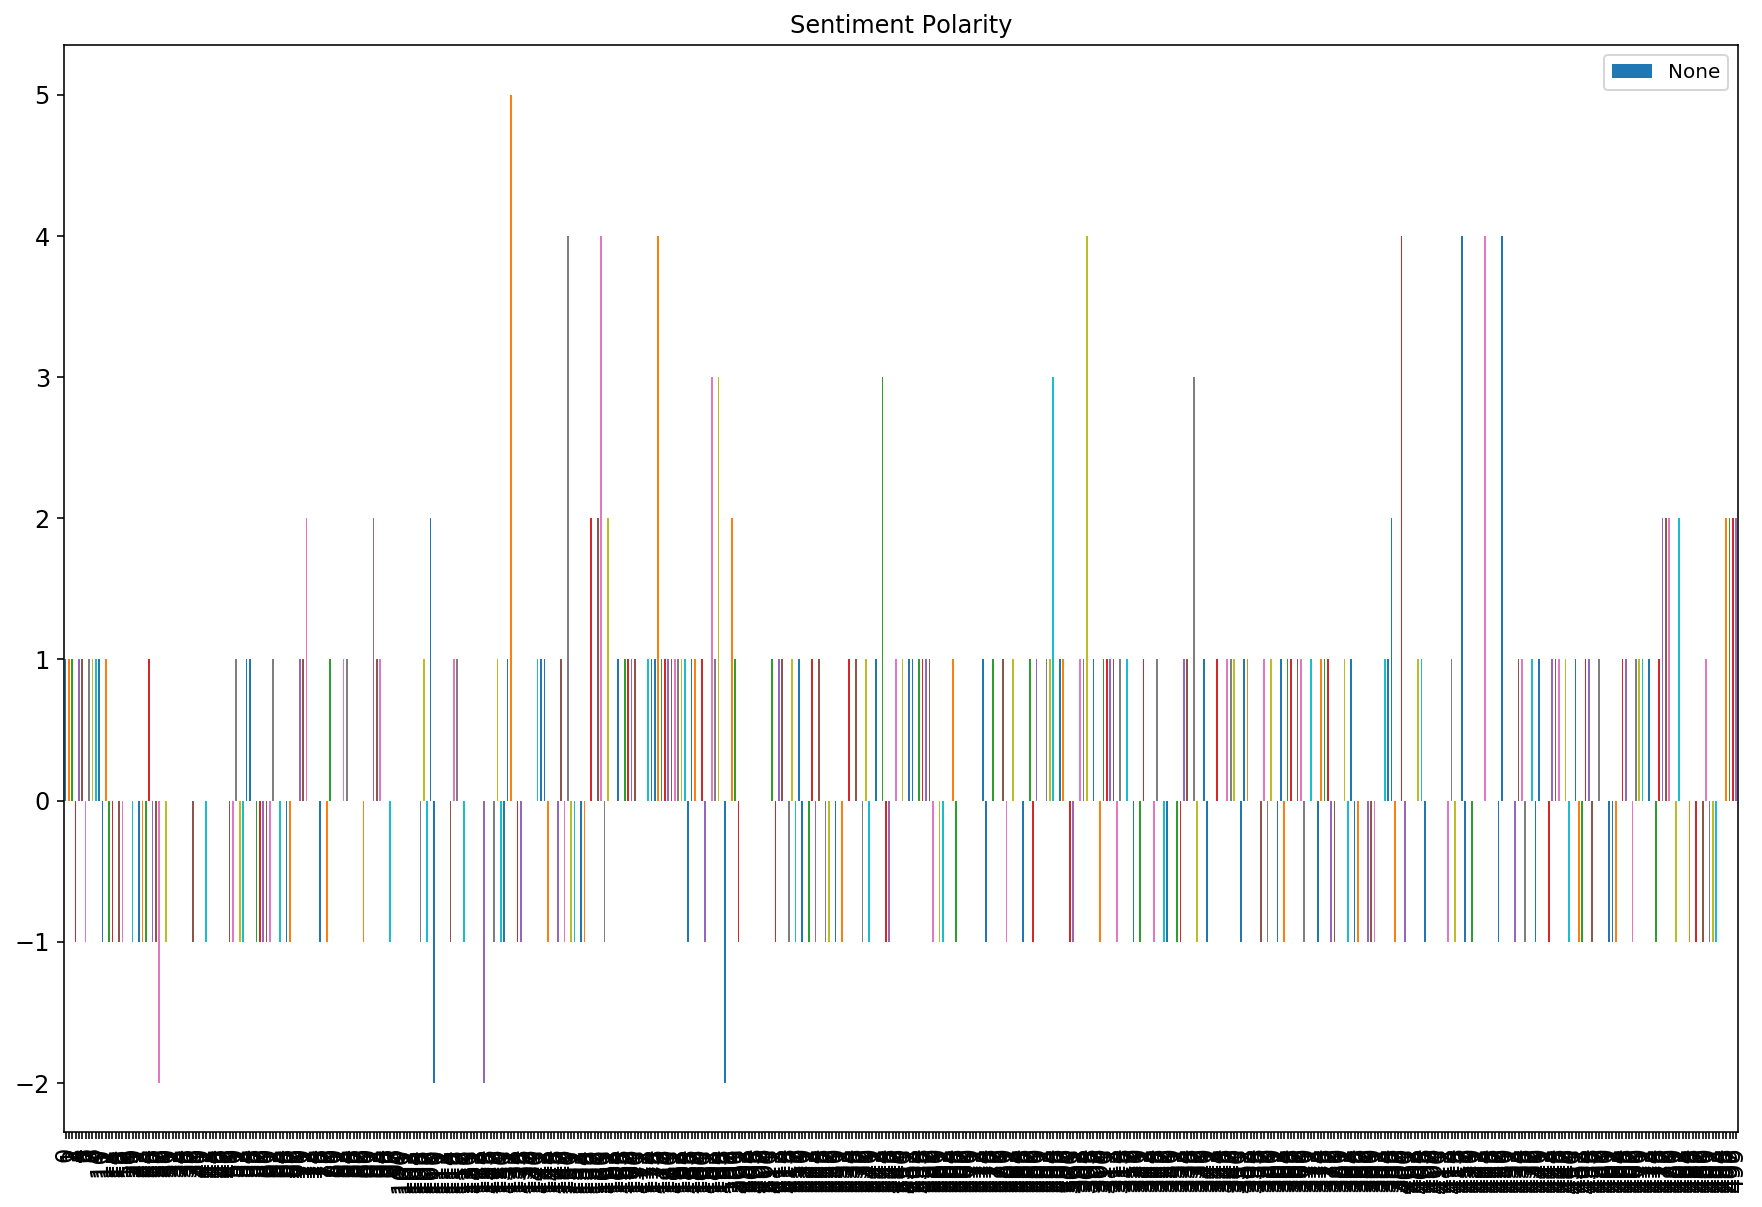

In [92]:
ax = df[['Sentiment']].count(axis=1).plot(kind='bar', title ="Sentiment Polarity", 
                                        figsize=(15, 10), legend=True, fontsize=12)


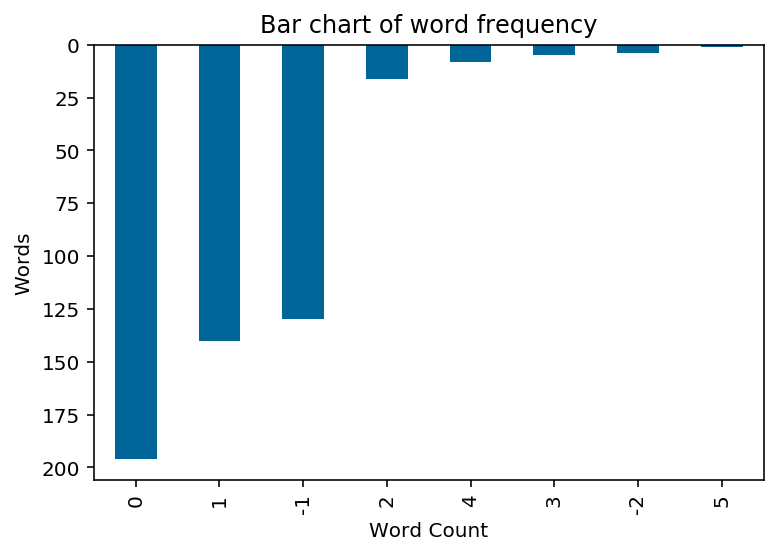

In [89]:
freq = df.groupby(['Sentiment']).size().reset_index(name='counts')
freq.sort_values(['counts'], ascending=False, inplace=True)
freq = freq.head(20)

freq.plot(kind='bar',x='Sentiment',y='counts', color='#006699')
ax = plt.gca().invert_yaxis()
plt.xlabel('Word Count')
plt.ylabel('Words')
plt.title('Bar chart of word frequency')
plt.legend().set_visible(False)

In [93]:
freq

,Sentiment,counts
2,0,196
3,1,140
1,-1,130
4,2,16
6,4,8
5,3,5
0,-2,4
7,5,1
